In [64]:
import numpy as np
import pandas as pd
import pickle
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
import xgboost as xgb
from sklearn import cross_validation
from sklearn import metrics

build function to find optimal n_estimators
note: if learning_rate, reg_alpha, reg_lambda are not set
xgboost will use default values from https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
e.g. eta = 0.3 instead of 0.1
if they are set, eta, alpha, lambda will be overwritten
the best n_estimators is Name + 1

In [65]:
def modelfit(model, data, label, cv=5, early_stopping_rounds=50):
    params = model.get_params()
    params["num_class"] = 5
    dtrain = xgb.DMatrix(data, label)
    cvresult = xgb.cv(params, dtrain, num_boost_round=model.get_params()["n_estimators"],
                      nfold=cv, stratified=True,
                      metrics="mlogloss", early_stopping_rounds=early_stopping_rounds, verbose_eval=50)
    print(cvresult.iloc[-1])
    
def modelsubmit(model, train_data, train_label, test_data, label_list):
    model.fit(train_data, train_label, eval_metric="mlogloss")
    test_predict = model.predict_proba(test_data)
    sample = pd.read_csv("input/sample_submission.csv")
    sample[label_list] = test_predict
    sample.to_csv("submit/xgb_grid.csv", index=False)
    
# define scorer for log_loss
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Load data

In [66]:
with open("data_processed_test.pkl", "rb") as f:
    train_data = pickle.load(f)
    train_label = pickle.load(f)
    test_data = pickle.load(f)
    test_label = pickle.load(f)
    label_list = pickle.load(f)

In [67]:
label_list

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

# Find n-estimators

In [5]:
xgb1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=5, min_child_weight=1,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb1, train_data, train_label)

[0]	train-mlogloss:1.53367+0.00185332	test-mlogloss:1.53544+0.00185385
[50]	train-mlogloss:0.911886+0.00341746	test-mlogloss:0.961532+0.0119965
[100]	train-mlogloss:0.860118+0.0034214	test-mlogloss:0.952447+0.0140473
test-mlogloss-mean     0.951768
test-mlogloss-std      0.013332
train-mlogloss-mean    0.871959
train-mlogloss-std     0.003462
Name: 85, dtype: float64


# Grid search max_depth and min_child_weight
n-estimators = 86

In [6]:
# grid search max_depth and min_child_weight
param_grid = [{"max_depth": [3, 5, 7, 9],
               "min_child_weight": [1, 3, 5]}]
xgb2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=86,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs2 = GridSearchCV(xgb2, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs2.fit(train_data, train_label)
gs2.grid_scores_, gs2.best_params_, gs2.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ....... max_depth=3, min_child_weight=1, score=-0.947563 -   4.3s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] ....... max_depth=3, min_child_weight=1, score=-0.943264 -   3.8s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


[CV] ....... max_depth=3, min_child_weight=1, score=-0.962575 -   4.3s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ....... max_depth=3, min_child_weight=1, score=-0.975412 -   5.1s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] ....... max_depth=3, min_child_weight=1, score=-0.950867 -   3.9s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] ....... max_depth=3, min_child_weight=3, score=-0.947378 -   4.5s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] ....... max_depth=3, min_child_weight=3, score=-0.944044 -   4.9s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] ....... max_depth=3, min_child_weight=3, score=-0.963401 -   5.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] ....... max_depth=3, min_child_weight=3, score=-0.975742 -   4.7s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.6min finished


([mean: -0.95593, std: 0.01166, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.95616, std: 0.01179, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.95620, std: 0.01155, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.95399, std: 0.01282, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.95420, std: 0.01262, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.95375, std: 0.01244, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.96802, std: 0.01382, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.96495, std: 0.01327, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.96252, std: 0.01312, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.99564, std: 0.01369, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.98404, std: 0.01434, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.97676, std: 0.01385, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

In [7]:
# grid search max_depth and min_child_weight
param_grid = [{"max_depth": [4, 5, 6],
               "min_child_weight": [5, 7, 9]}]
xgb3 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=86,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs3 = GridSearchCV(xgb3, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs3.fit(train_data, train_label)
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=4, min_child_weight=5 .................................
[CV] ....... max_depth=4, min_child_weight=5, score=-0.940993 -   5.3s
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ....... max_depth=4, min_child_weight=5, score=-0.939377 -   5.5s
[CV] max_depth=4, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s


[CV] ....... max_depth=4, min_child_weight=5, score=-0.960727 -   5.7s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] ....... max_depth=4, min_child_weight=5, score=-0.972107 -   5.2s
[CV] max_depth=4, min_child_weight=5 .................................
[CV] ....... max_depth=4, min_child_weight=5, score=-0.950481 -   5.3s
[CV] max_depth=4, min_child_weight=7 .................................
[CV] ....... max_depth=4, min_child_weight=7, score=-0.941001 -   5.3s
[CV] max_depth=4, min_child_weight=7 .................................
[CV] ....... max_depth=4, min_child_weight=7, score=-0.939552 -   5.4s
[CV] max_depth=4, min_child_weight=7 .................................
[CV] ....... max_depth=4, min_child_weight=7, score=-0.961463 -   5.1s
[CV] max_depth=4, min_child_weight=7 .................................
[CV] ....... max_depth=4, min_child_weight=7, score=-0.972083 -   5.2s
[CV] max_depth=4, min_child_weight=7 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.7min finished


([mean: -0.95273, std: 0.01233, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.95289, std: 0.01239, params: {'max_depth': 4, 'min_child_weight': 7},
  mean: -0.95267, std: 0.01199, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: -0.95375, std: 0.01244, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.95363, std: 0.01246, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.95331, std: 0.01230, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.95716, std: 0.01257, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.95655, std: 0.01192, params: {'max_depth': 6, 'min_child_weight': 7},
  mean: -0.95611, std: 0.01182, params: {'max_depth': 6, 'min_child_weight': 9}],
 {'max_depth': 4, 'min_child_weight': 9},
 -0.9526653374182557)

In [8]:
# grid search max_depth and min_child_weight
param_grid = [{"max_depth": [4, 5],
               "min_child_weight": [9, 11]}]
xgb4 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=86,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs4 = GridSearchCV(xgb4, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs4.fit(train_data, train_label)
gs4.grid_scores_, gs4.best_params_, gs4.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=4, min_child_weight=9 .................................
[CV] ....... max_depth=4, min_child_weight=9, score=-0.942033 -   5.4s
[CV] max_depth=4, min_child_weight=9 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] ....... max_depth=4, min_child_weight=9, score=-0.939041 -   5.3s
[CV] max_depth=4, min_child_weight=9 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.7s remaining:    0.0s


[CV] ....... max_depth=4, min_child_weight=9, score=-0.959757 -   5.4s
[CV] max_depth=4, min_child_weight=9 .................................
[CV] ....... max_depth=4, min_child_weight=9, score=-0.971802 -   5.5s
[CV] max_depth=4, min_child_weight=9 .................................
[CV] ....... max_depth=4, min_child_weight=9, score=-0.950718 -   5.1s
[CV] max_depth=4, min_child_weight=11 ................................
[CV] ...... max_depth=4, min_child_weight=11, score=-0.942641 -   4.8s
[CV] max_depth=4, min_child_weight=11 ................................
[CV] ...... max_depth=4, min_child_weight=11, score=-0.938360 -   4.8s
[CV] max_depth=4, min_child_weight=11 ................................
[CV] ...... max_depth=4, min_child_weight=11, score=-0.960768 -   5.2s
[CV] max_depth=4, min_child_weight=11 ................................
[CV] ...... max_depth=4, min_child_weight=11, score=-0.973077 -   5.3s
[CV] max_depth=4, min_child_weight=11 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished


([mean: -0.95267, std: 0.01199, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: -0.95318, std: 0.01256, params: {'max_depth': 4, 'min_child_weight': 11},
  mean: -0.95331, std: 0.01230, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.95330, std: 0.01240, params: {'max_depth': 5, 'min_child_weight': 11}],
 {'max_depth': 4, 'min_child_weight': 9},
 -0.9526653374182557)

In [10]:
# grid search max_depth and min_child_weight
param_grid = [{"max_depth": [4],
               "min_child_weight": [8, 9, 10]}]
xgb5 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=86,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs5 = GridSearchCV(xgb5, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs5.fit(train_data, train_label)
gs5.grid_scores_, gs5.best_params_, gs5.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=4, min_child_weight=8 .................................
[CV] ....... max_depth=4, min_child_weight=8, score=-0.941511 -   5.3s
[CV] max_depth=4, min_child_weight=8 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ....... max_depth=4, min_child_weight=8, score=-0.939234 -   4.9s
[CV] max_depth=4, min_child_weight=8 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV] ....... max_depth=4, min_child_weight=8, score=-0.960350 -   5.2s
[CV] max_depth=4, min_child_weight=8 .................................
[CV] ....... max_depth=4, min_child_weight=8, score=-0.971452 -   4.9s
[CV] max_depth=4, min_child_weight=8 .................................
[CV] ....... max_depth=4, min_child_weight=8, score=-0.950222 -   4.8s
[CV] max_depth=4, min_child_weight=9 .................................
[CV] ....... max_depth=4, min_child_weight=9, score=-0.942033 -   5.0s
[CV] max_depth=4, min_child_weight=9 .................................
[CV] ....... max_depth=4, min_child_weight=9, score=-0.939041 -   5.5s
[CV] max_depth=4, min_child_weight=9 .................................
[CV] ....... max_depth=4, min_child_weight=9, score=-0.959757 -   5.0s
[CV] max_depth=4, min_child_weight=9 .................................
[CV] ....... max_depth=4, min_child_weight=9, score=-0.971802 -   5.5s
[CV] max_depth=4, min_child_weight=9 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min finished


([mean: -0.95255, std: 0.01202, params: {'max_depth': 4, 'min_child_weight': 8},
  mean: -0.95267, std: 0.01199, params: {'max_depth': 4, 'min_child_weight': 9},
  mean: -0.95297, std: 0.01216, params: {'max_depth': 4, 'min_child_weight': 10}],
 {'max_depth': 4, 'min_child_weight': 8},
 -0.9525491723518706)

# Grid search gamma
n_estimators = 86, max_depth = 4, min_child_weight = 8

In [11]:
param_grid = [{"gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5]}]
xgb6 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=86,
                         max_depth=4, min_child_weight=8,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs6 = GridSearchCV(xgb6, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs6.fit(train_data, train_label)
gs6.grid_scores_, gs6.best_params_, gs6.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.941511 -   6.4s
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ............................... gamma=0, score=-0.939234 -   5.8s
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.2s remaining:    0.0s


[CV] ............................... gamma=0, score=-0.960350 -   5.9s
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.971452 -   5.9s
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.950222 -   6.9s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.941690 -   5.6s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.938735 -   5.7s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.960157 -   6.1s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.971785 -   5.5s
[CV] gamma=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.8min finished


([mean: -0.95255, std: 0.01202, params: {'gamma': 0},
  mean: -0.95249, std: 0.01219, params: {'gamma': 0.1},
  mean: -0.95250, std: 0.01197, params: {'gamma': 0.2},
  mean: -0.95252, std: 0.01209, params: {'gamma': 0.3},
  mean: -0.95271, std: 0.01206, params: {'gamma': 0.4},
  mean: -0.95274, std: 0.01214, params: {'gamma': 0.5}],
 {'gamma': 0.1},
 -0.9524896448232184)

# Find n-estimators
max_depth = 4, min_child_weight = 8, gamma = 0.1

In [12]:
xgb7 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=4, min_child_weight=8,
                         gamma=0.1,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb7, train_data, train_label)

[0]	train-mlogloss:1.53594+0.00178116	test-mlogloss:1.53688+0.00186833
[50]	train-mlogloss:0.9422+0.00297708	test-mlogloss:0.965447+0.0100019
[100]	train-mlogloss:0.90795+0.00345846	test-mlogloss:0.951844+0.0123828
[150]	train-mlogloss:0.890955+0.00368061	test-mlogloss:0.952867+0.0135877
test-mlogloss-mean     0.951671
test-mlogloss-std      0.012802
train-mlogloss-mean    0.901434
train-mlogloss-std     0.003588
Name: 117, dtype: float64


# Grid search subsample, colsample_bytree
n_estimators = 118, max_depth = 4, min_child_weight = 8, gamma = 0.1

In [13]:
param_grid8 = [{"subsample": [0.6, 0.7, 0.8, 0.9],
                 "colsample_bytree": [0.6, 0.7, 0.8, 0.9]}]
xgb8 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=118,
                         max_depth=4, min_child_weight=8,
                         gamma=0.1,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs8 = GridSearchCV(xgb8, param_grid8, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs8.fit(train_data, train_label)
gs8.grid_scores_, gs8.best_params_, gs8.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.940323 -   6.2s
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.936649 -   6.0s
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s


[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.959963 -   6.0s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.970876 -   5.9s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.949195 -   6.1s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.939753 -   5.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.939112 -   5.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.958484 -   5.8s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.969728 -   5.7s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  9.9min finished


([mean: -0.95140, std: 0.01263, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.95092, std: 0.01172, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.95083, std: 0.01215, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.95107, std: 0.01166, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.95223, std: 0.01328, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.95146, std: 0.01247, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.95129, std: 0.01223, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.95131, std: 0.01130, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.95271, std: 0.01287, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.95107, std: 0.01225, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.95201, std: 0.01238, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.95203, std: 0.01176, params: {'colsample_bytree': 0.8,

In [15]:
param_grid9 = [{"subsample": [0.75, 0.8, 0.85],
                 "colsample_bytree": [0.65, 0.7, 0.75]}]
xgb9 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=118,
                         max_depth=4, min_child_weight=8,
                         gamma=0.1,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs9 = GridSearchCV(xgb9, param_grid9, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs9.fit(train_data, train_label)
gs9.grid_scores_, gs9.best_params_, gs9.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] colsample_bytree=0.65, subsample=0.75 ...........................
[CV] . colsample_bytree=0.65, subsample=0.75, score=-0.940126 -   6.0s
[CV] colsample_bytree=0.65, subsample=0.75 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] . colsample_bytree=0.65, subsample=0.75, score=-0.938283 -   6.0s
[CV] colsample_bytree=0.65, subsample=0.75 ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[CV] . colsample_bytree=0.65, subsample=0.75, score=-0.960088 -   7.1s
[CV] colsample_bytree=0.65, subsample=0.75 ...........................
[CV] . colsample_bytree=0.65, subsample=0.75, score=-0.970676 -   6.3s
[CV] colsample_bytree=0.65, subsample=0.75 ...........................
[CV] . colsample_bytree=0.65, subsample=0.75, score=-0.949548 -   6.6s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV] .. colsample_bytree=0.65, subsample=0.8, score=-0.940019 -   6.7s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV] .. colsample_bytree=0.65, subsample=0.8, score=-0.938709 -   6.9s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV] .. colsample_bytree=0.65, subsample=0.8, score=-0.959874 -   6.8s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV] .. colsample_bytree=0.65, subsample=0.8, score=-0.970150 -   6.5s
[CV] colsample_bytree=0.65, subsample=0.8 ............................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.7min finished


([mean: -0.95174, std: 0.01224, params: {'colsample_bytree': 0.65, 'subsample': 0.75},
  mean: -0.95178, std: 0.01196, params: {'colsample_bytree': 0.65, 'subsample': 0.8},
  mean: -0.95138, std: 0.01166, params: {'colsample_bytree': 0.65, 'subsample': 0.85},
  mean: -0.95168, std: 0.01226, params: {'colsample_bytree': 0.7, 'subsample': 0.75},
  mean: -0.95129, std: 0.01223, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.95136, std: 0.01206, params: {'colsample_bytree': 0.7, 'subsample': 0.85},
  mean: -0.95159, std: 0.01212, params: {'colsample_bytree': 0.75, 'subsample': 0.75},
  mean: -0.95110, std: 0.01246, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: -0.95126, std: 0.01192, params: {'colsample_bytree': 0.75, 'subsample': 0.85}],
 {'colsample_bytree': 0.75, 'subsample': 0.8},
 -0.9510992979999632)

# Grid search reg_alpha
n_estimators = 118, max_depth = 4, min_child_weight = 8, gamma = 0.1, colsample_bytree = 0.75, subsample = 0.8

In [17]:
param_grid10 = [{"reg_alpha": [0.001, 0.005, 0.01, 0.05]}]
xgb10 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=118,
                         max_depth=4, min_child_weight=8,
                         gamma=0.1,
                         subsample=0.8, colsample_bytree=0.75,
                         reg_lambda=1,
                         objective="multi:softprob")
gs10 = GridSearchCV(xgb10, param_grid10, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs10.fit(train_data, train_label)
gs10.grid_scores_, gs10.best_params_, gs10.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.939464 -   6.7s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] ....................... reg_alpha=0.001, score=-0.937084 -   6.9s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s


[CV] ....................... reg_alpha=0.001, score=-0.960800 -   6.5s
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.969119 -   7.5s
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.948789 -   6.5s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.939564 -   6.5s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.937428 -   6.5s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.960794 -   7.1s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.968542 -   6.9s
[CV] reg_alpha=0.005 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.4min finished


([mean: -0.95105, std: 0.01230, params: {'reg_alpha': 0.001},
  mean: -0.95098, std: 0.01204, params: {'reg_alpha': 0.005},
  mean: -0.95087, std: 0.01209, params: {'reg_alpha': 0.01},
  mean: -0.95074, std: 0.01234, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 -0.9507430974015214)

# Grid search reg_lambda
n_estimators = 118, max_depth = 4, min_child_weight = 8, 
gamma = 0.1, colsample_bytree = 0.75, subsample = 0.8, reg_alpha = 0.05

In [19]:
param_grid11 = [{"reg_lambda": [1e-5, 0.01, 0.1, 1, 100]}]
xgb11 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=118,
                         max_depth=4, min_child_weight=8,
                         gamma=0.1,
                         subsample=0.8, colsample_bytree=0.75,
                         reg_alpha=0.05,
                         objective="multi:softprob")
gs11 = GridSearchCV(xgb11, param_grid11, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs11.fit(train_data, train_label)
gs11.grid_scores_, gs11.best_params_, gs11.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.939502 -   6.8s
[CV] reg_lambda=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] ...................... reg_lambda=1e-05, score=-0.936256 -   6.6s
[CV] reg_lambda=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV] ...................... reg_lambda=1e-05, score=-0.961342 -   8.1s
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.969596 -   8.3s
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.948598 -   8.5s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.939661 -   7.5s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.936524 -   7.3s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.961626 -   6.3s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.969034 -   6.1s
[CV] reg_lambda=0.01 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.8min finished


([mean: -0.95105, std: 0.01271, params: {'reg_lambda': 1e-05},
  mean: -0.95111, std: 0.01250, params: {'reg_lambda': 0.01},
  mean: -0.95101, std: 0.01244, params: {'reg_lambda': 0.1},
  mean: -0.95074, std: 0.01234, params: {'reg_lambda': 1},
  mean: -0.95782, std: 0.01136, params: {'reg_lambda': 100}],
 {'reg_lambda': 1},
 -0.9507430974015214)

# Find n_estimators final
max_depth = 4, min_child_weight = 8, 
gamma = 0.1, colsample_bytree = 0.75, subsample = 0.8, reg_alpha = 0.05, reg_lambda = 1

In [20]:
# find n_estimators
xgb12 = xgb.XGBClassifier(learning_rate=0.01, n_estimators=5000,
                         max_depth=4, min_child_weight=8,
                         gamma=0.1,
                         subsample=0.8, colsample_bytree=0.75,
                         reg_alpha=0.05, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb12, train_data, train_label)

[0]	train-mlogloss:1.60241+0.000195095	test-mlogloss:1.60247+0.000172517
[50]	train-mlogloss:1.34086+0.00125513	test-mlogloss:1.34395+0.0022998
[100]	train-mlogloss:1.19706+0.0011206	test-mlogloss:1.20266+0.00438189
[150]	train-mlogloss:1.11073+0.00179842	test-mlogloss:1.11865+0.00536462
[200]	train-mlogloss:1.0558+0.00209081	test-mlogloss:1.06601+0.00646155
[250]	train-mlogloss:1.0195+0.00230583	test-mlogloss:1.03189+0.00740093
[300]	train-mlogloss:0.994248+0.00248015	test-mlogloss:1.00872+0.00811954
[350]	train-mlogloss:0.976089+0.00256691	test-mlogloss:0.992575+0.00878622
[400]	train-mlogloss:0.96275+0.00264236	test-mlogloss:0.98122+0.00930948
[450]	train-mlogloss:0.952583+0.00267726	test-mlogloss:0.973062+0.00974911
[500]	train-mlogloss:0.944603+0.00275509	test-mlogloss:0.967011+0.0100262
[550]	train-mlogloss:0.938166+0.00280402	test-mlogloss:0.962555+0.0103607
[600]	train-mlogloss:0.932881+0.00286441	test-mlogloss:0.9593+0.0106986
[650]	train-mlogloss:0.928471+0.00294044	test-mlog

In [68]:
xgbfinal = xgb.XGBClassifier(learning_rate=0.01, n_estimators=1164,
                         max_depth=4, min_child_weight=8,
                         gamma=0.1,
                         subsample=0.8, colsample_bytree=0.75,
                         reg_alpha=0.05, reg_lambda=1,
                         objective="multi:softprob")
#modelsubmit(xgbfinal, train_data, train_label, test_data, label_list)

In [69]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [70]:
xgbfinal.fit(train_data,train_label)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.75,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=8, missing=None, n_estimators=1164, nthread=-1,
       objective='multi:softprob', reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

# Predict and compute accuracy 

In [71]:
from sklearn.metrics import accuracy_score
y_pred = xgbfinal.predict(test_data)
predict_label = [round(value) for value in y_pred]
accuracy = accuracy_score(test_label, predict_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 58.13%


In [83]:
xgbfinal.score(test_data, test_label)

0.58129032258064517

In [82]:
metrics.precision_recall_fscore_support(test_label, predict_label)

/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 0.62919255,  0.        ,  0.54166667,  0.45989305,  0.65680473]),
 array([ 0.78527132,  0.        ,  0.15294118,  0.50647821,  0.42912371]),
 array([ 0.69862069,  0.        ,  0.23853211,  0.48206278,  0.51909587]),
 array([1290,   15,  170,  849,  776]))

# Feature importances

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [29]:
features = ['Size', 'HasName_0', 'HasName_1', 'TimeofDay_lateday',
       'TimeofDay_midday', 'TimeofDay_morning', 'TimeofDay_night', 'WeekDay_0',
       'WeekDay_1', 'WeekDay_2', 'WeekDay_3', 'WeekDay_4', 'WeekDay_5',
       'WeekDay_6', 'IsIntact_0', 'IsIntact_1', 'IsIntact_Unknown',
       'Sex_Female', 'Sex_Male', 'Sex_Unknown', 'IsMixBreed_0', 'IsMixBreed_1',
       'MixorMultipleorSimple_Mix', 'MixorMultipleorSimple_Multiple',
       'MixorMultipleorSimple_Simple', 'Group_Herding', 'Group_Hound',
       'Group_NonSporting', 'Group_PitBull', 'Group_Sporting', 'Group_Terrier',
       'Group_Toy', 'Group_Unknown', 'Group_Working', 'IsMixColor_0',
       'IsMixColor_1']
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(xgbfinal.booster().get_fscore())
#ts.index = ts.reset_index()['index'].map(mapFeat)
#ts.order().plot(kind="barh", title=("features importance"))

In [32]:
ts = ts.sort_values(ascending=False)

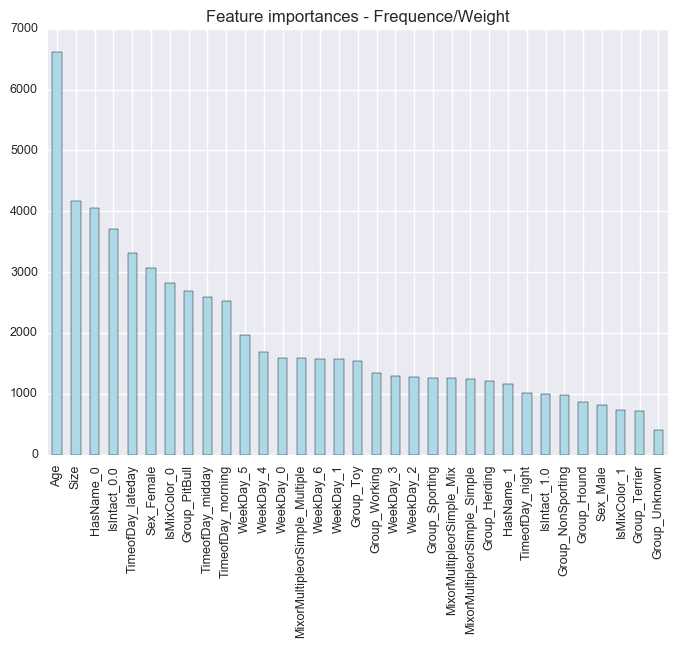

In [33]:
plt.figure(); ts.plot(color="lightblue", kind="bar", title="Feature importances - Frequence/Weight",fontsize=9,)

In [34]:
#xgb.plot_importance(xgbfinal)

In [47]:
ts1 = pd.Series(xgbfinal.booster().get_score(importance_type = "gain"))

In [48]:
ts1 = ts1.sort_values(ascending=False)

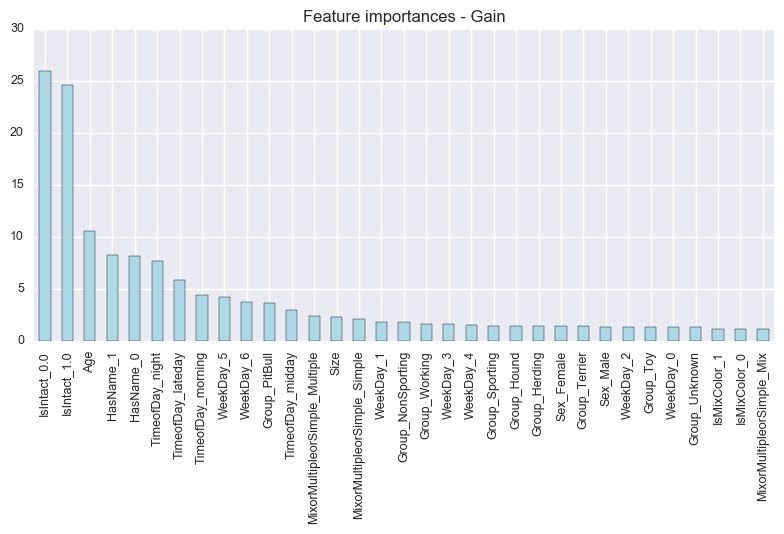

In [49]:
plt.figure(); ts1.plot(color="lightblue", kind="bar", title="Feature importances - Gain",fontsize=9)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("gain.png")

In [40]:
ts2 = pd.Series(xgbfinal.booster().get_score(importance_type = "weight"))

In [41]:
ts2 = ts2.sort_values(ascending=False)

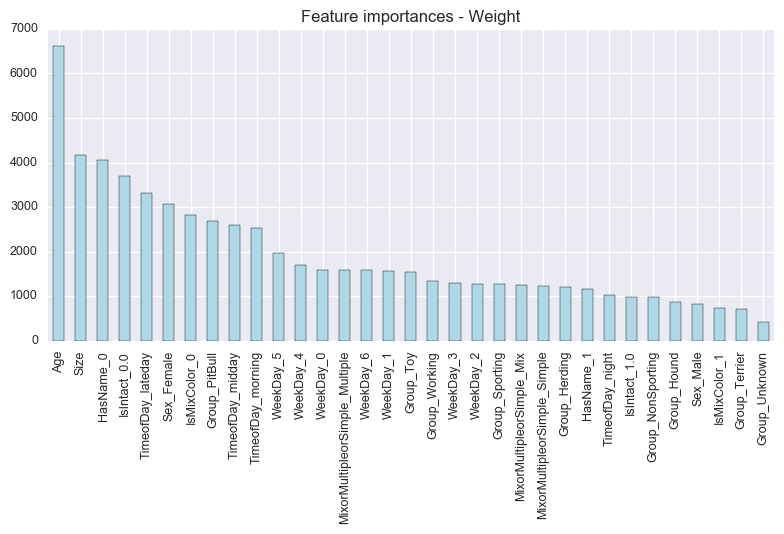

In [42]:
plt.figure(); ts2.plot(color="lightblue", kind="bar", title="Feature importances - Weight",fontsize=9,)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("weight.png")

In [43]:
ts3 = pd.Series(xgbfinal.booster().get_score(importance_type = "cover"))

In [44]:
ts3 = ts3.sort_values(ascending=False)

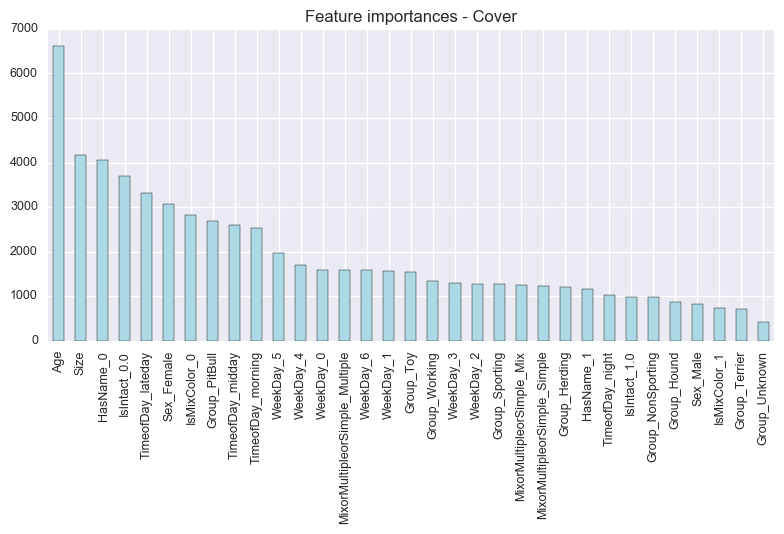

In [46]:
plt.figure(); ts3.plot(color="lightblue", kind="bar", title="Feature importances - Cover",fontsize=9,)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("cover.png")

In [51]:
plt.close

<function matplotlib.pyplot.close>